In [1]:
from Testing_Stacks import *

In [2]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )

2022-06-08 18:21:47.016899: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-08 18:21:50.178437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-08 18:21:50.179848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9629 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-08 18:21:50.181466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [3]:
model.load_weights('convlstm_weights.h5')

In [4]:
def get_yy_hat(model_name, model):
    X, Y = load_dataset(model_name, mon = True, temp = True)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    for xx, yy in itertools.islice(generator, 0, 1, 1):
        print(xx.shape, yy.shape)
    yy_hat = model.predict(generator)
    print(yy_hat.shape)
    np.save(rf"npy_Files/yy_hat_{model_name}_mon_temp.npy", yy_hat)

In [5]:
get_yy_hat('MIROC-ESM', model)

Mean of GCM Data:  77.65176921123529
Variance of GCM Data:  127.68268864741641
Mean of Obseved Data:  2.5495193302576267
Variance of Obseved Data:  6.952392465798967
(1, 4, 129, 135, 7) (1, 129, 135, 1)


2022-06-08 18:22:15.556822: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-06-08 18:22:15.871880: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-06-08 18:22:16.060532: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(692, 129, 135, 1)


In [6]:
get_yy_hat('CanESM2', model)

Mean of GCM Data:  77.88684254498882
Variance of GCM Data:  128.07464045963928
Mean of Obseved Data:  2.5495193302576267
Variance of Obseved Data:  6.952392465798967
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(692, 129, 135, 1)


In [7]:
get_yy_hat('GFDL-CM3', model)

Mean of GCM Data:  82.47856094470656
Variance of GCM Data:  129.34692357455242
Mean of Obseved Data:  2.5495193302576267
Variance of Obseved Data:  6.952392465798967
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(692, 129, 135, 1)


In [8]:
from tqdm import tqdm
def get_RMSE(model_name):
    X, Y = load_dataset(model_name, mon = True, temp = True)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    yy_hat = np.load(rf"npy_Files/yy_hat_{model_name}_mon_temp.npy")
    rmse = np.zeros((129,135))
    rmse_hist = np.zeros((yy_hat.shape[0],129,135))
    cnt = 0
    for xx, yy in tqdm(itertools.islice(generator, 0, None, 1)):
        yy_pred = yy_hat[cnt].reshape(129,135)
        yy = yy.reshape(129,135)
        rmse += np.square(yy - yy_pred)
        cnt += 1
        rmse_hist[cnt-1] = np.sqrt(rmse/cnt)
    rmse = np.sqrt(rmse/cnt)
    np.save(rf"npy_Files/rmse_hist_{model_name}_mon_temp.npy", rmse_hist)
    plot_RMSE(model_name)
    
def plot_RMSE(model_name):
    rmse = np.load(rf"npy_Files/rmse_hist_{model_name}_mon_temp.npy")[-1]
    
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM_US.npy"
    elev = np.load(FileName)
    mask = np.zeros((129,135))
    mask[39:90,12:123] = np.array(elev)
    indices = np.where(mask == 0)
    rmse[indices] = np.nan

    fig,ax = plt.subplots(1,2, figsize = (20,10))
    sns.heatmap(np.flip(rmse, axis = 0), cmap = 'rainbow', ax =ax[0])
    ax[0].axis('off')
    ax[1].boxplot(rmse[~np.isnan(rmse)], vert = False)
    plt.suptitle(f"{model_name} : RMSE Plot", fontsize = 16)

Mean of GCM Data:  77.65176921123529
Variance of GCM Data:  127.68268864741641
Mean of Obseved Data:  2.5495193302576267
Variance of Obseved Data:  6.952392465798967


692it [00:01, 629.93it/s]


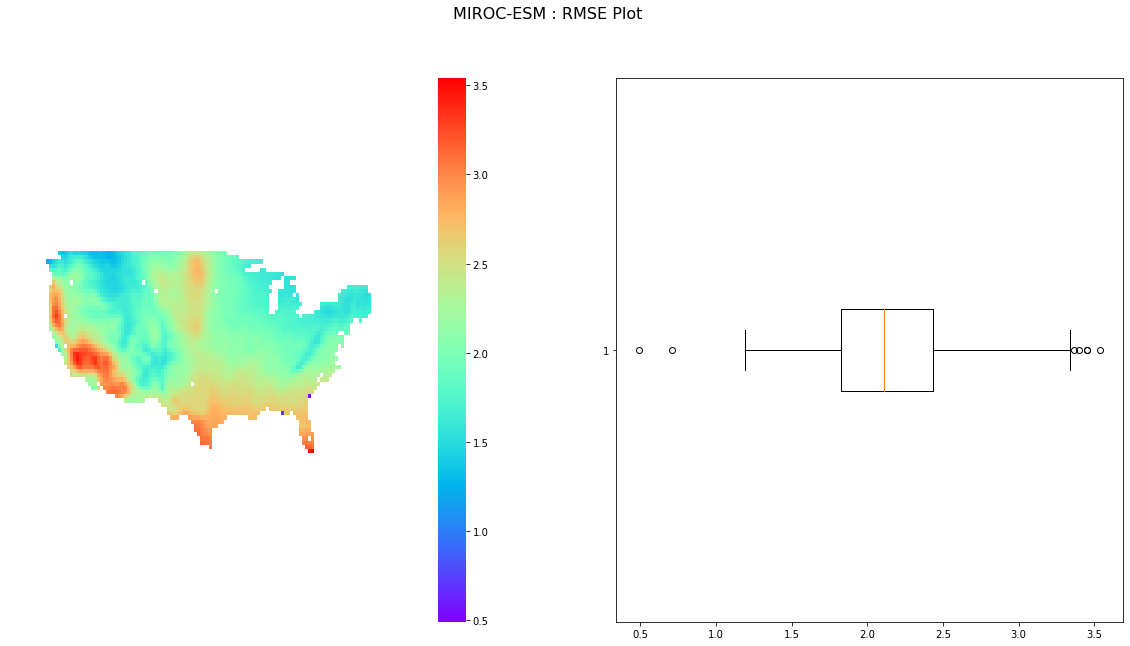

In [9]:
get_RMSE('MIROC-ESM')

Mean of GCM Data:  77.88684254498882
Variance of GCM Data:  128.07464045963928
Mean of Obseved Data:  2.5495193302576267
Variance of Obseved Data:  6.952392465798967


692it [00:00, 788.22it/s]


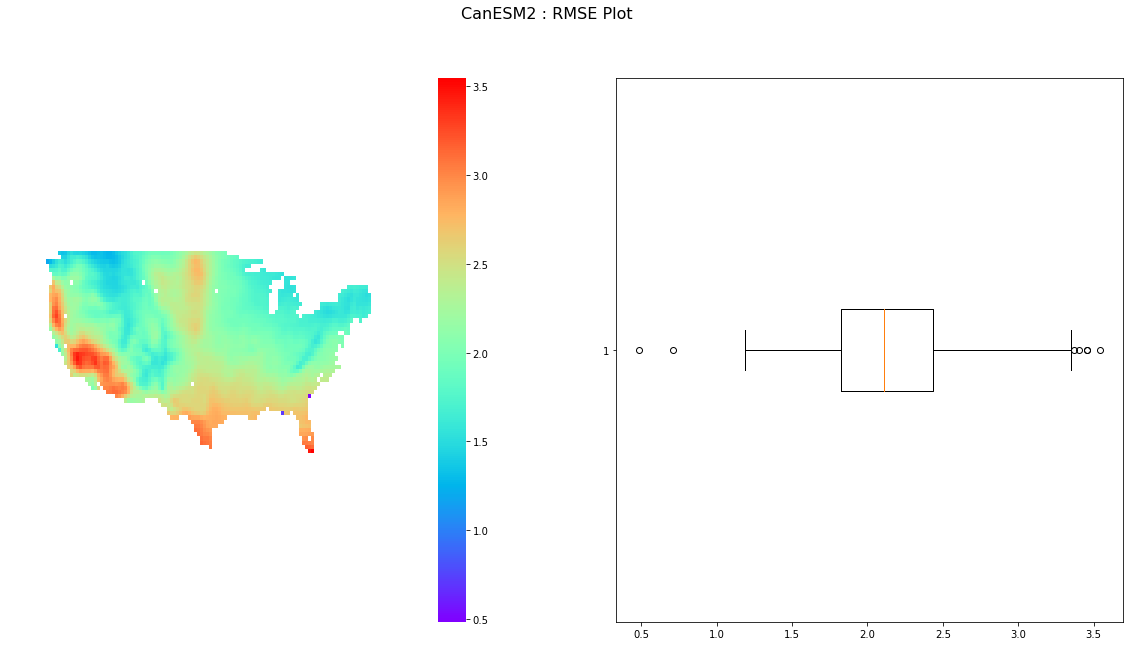

In [10]:
get_RMSE('CanESM2')

Mean of GCM Data:  82.47856094470656
Variance of GCM Data:  129.34692357455242
Mean of Obseved Data:  2.5495193302576267
Variance of Obseved Data:  6.952392465798967


692it [00:01, 590.14it/s]


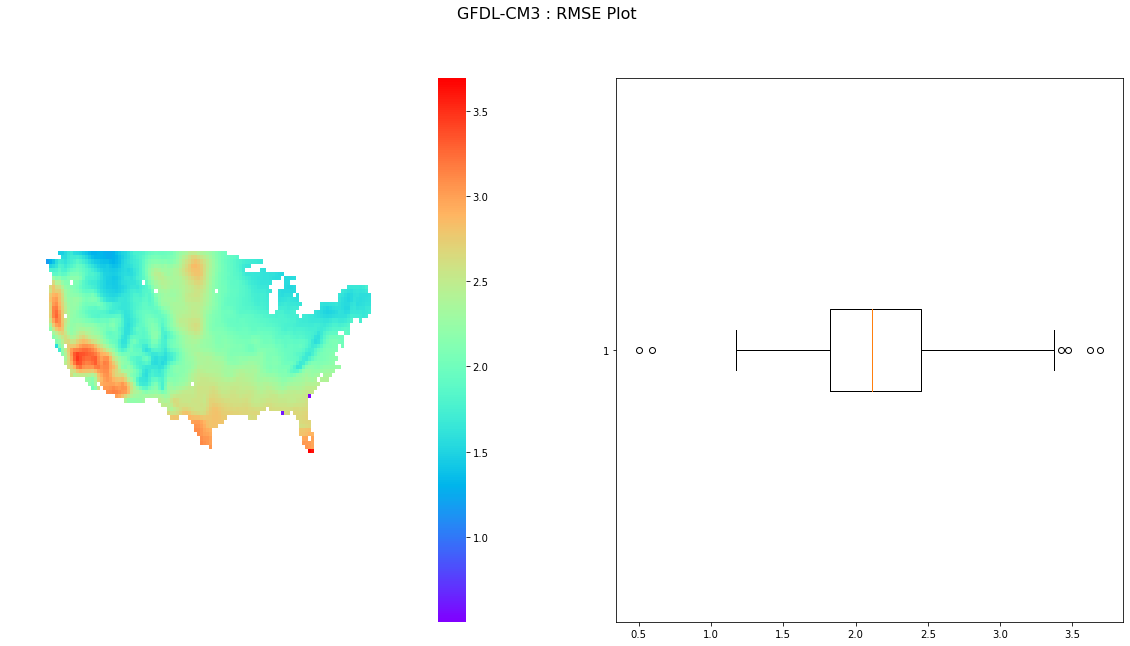

In [11]:
get_RMSE('GFDL-CM3')